<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/BlackScholes_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Black-Scholes Partial Differential Equation (PDE)
The value of an option $V(S, t)$ satisfies the Black-Scholes PDE:
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

### Initial and Boundary Conditions of the Black-Scholes PDE

The initial and boundary conditions for the Black-Scholes PDE depend on the type of derivative being priced, such as European call or put options. These conditions are necessary for solving the PDE and obtaining specific option prices. We will consider a Call option.

- $\textbf{Initial Condition}$ (at $t = T$):
    - $\text{Call: } V(S, T) = \max(S - K, 0)$ \\
- $\textbf{Boundary Conditions:}$
  - $V(0, t) = 0$ \\
  - $V(S, t) \to S - K e^{-r(T-t)} \quad \text{as } S \to \infty$

These conditions, combined with the Black-Scholes PDE, provide a complete specification for determining the price of the option.


## Implementation

In [1]:
import torch
import torch.nn.functional as F

## Analytic formula

In [2]:
import torch

def black_scholes(S, t, T=1.0, K=120, r=0.05, sigma=0.20, option_type="call"):
    """
    Compute the Black-Scholes option price.

    Args:
        S (torch.Tensor): Current stock price.
        T (float): Time to maturity.
        t (float): Current time (typically 0).
        K (float): Strike price.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the stock price.
        option_type (str): "call" or "put".

    Returns:
        torch.Tensor: Option price.
    """
    # Ensure inputs are PyTorch tensors and have the correct dtype
    S = S.type(torch.float32) # Changed to type casting

    # Time to maturity
    tau = T - t

    # Avoid division by zero for tau = 0
    epsilon = 1e-8

    # Convert r and tau to tensors
    r = torch.tensor(r, dtype=torch.float32)
    tau = torch.tensor(tau, dtype=torch.float32)

    # Compute d1 and d2
    # Use tau and epsilon directly for torch.sqrt, no need to create new tensors
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * torch.sqrt(tau + epsilon))
    d2 = d1 - sigma * torch.sqrt(tau + epsilon)

    # Compute N(d1) and N(d2) using the cumulative distribution function
    N_d1 = 0.5 * (1.0 + torch.erf(d1 / torch.sqrt(torch.tensor(2.0))))
    N_d2 = 0.5 * (1.0 + torch.erf(d2 / torch.sqrt(torch.tensor(2.0))))

    # Compute the call or put price
    if option_type == "call":
        option_price = S * N_d1 - K * torch.exp(-r * tau) * N_d2
    elif option_type == "put":
        option_price = K * torch.exp(-r * tau) * (1.0 - N_d2) - S * (1.0 - N_d1)
    else:
        raise ValueError("Invalid option_type. Must be 'call' or 'put'.")

    return option_price

In [3]:
# black_scholes(S, t, T=1.0, K=120, r=0.05, sigma=0.20, option_type="call"):
S = torch.tensor([100.0], dtype=torch.float32)  # Stock price
t = 0.0    # Current time
T = 1.0    # Time to maturity
K = 100.0  # Strike price
r = 0.05   # Risk-free rate
sigma = 0.2  # Volatility

# Compute call and put prices
call_price = black_scholes(S, t, T, K, r, sigma, option_type="call")
print(f"Call Price: {call_price.item():.4f}")

Call Price: 10.4506


In [4]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [11]:
def bs_pde_residual(model, s, t, r=0.05, sigma=0.20):
    """
    Compute the PDE residual for Black-Scholes equation:
    """
    s.requires_grad = True
    t.requires_grad = True
    V = model(torch.cat((s, t), dim=1))

    # Gradients w.r.t. x and t
    V_s = torch.autograd.grad(V, s, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    # Second-order derivative w.r.t. s
    V_ss = torch.autograd.grad(V_s, s, grad_outputs=torch.ones_like(V_s), create_graph=True)[0]

    # PDE residual
    residual = V_t + 0.5*sigma**2*s**2*V_ss + r*s*V_s -r*V
    return residual

# Step 2: Define the PINN model
class PINN(nn.Module):
    """Physics-Informed Neural Network for heat equation."""
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50),  # Inputs: (s, t)
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: V(s, t)
        )

    def forward(self, s):
        return self.hidden_layers(s)

# Step 3: Define the loss function
def compute_loss(model, s_interior, t_interior, s_boundary, t_boundary,
                 s_initial, t_initial, V_initial,
                 r, sigma):
    """Compute the combined loss for the PDE residual, boundary, and initial conditions."""
    # PDE residual loss
    residual = bs_pde_residual(model, s_interior, t_interior, r, sigma)
    pde_loss = torch.mean(residual**2)

    # Boundary condition loss:
    # V(0, t)=0
    # V(S, t)→S-K*exp(−r(T−t))as 𝑆→∞
    V_boundary_left = model(torch.cat((s_boundary[0], t_boundary), dim=1))
    V_boundary_right = model(torch.cat((s_boundary[1], t_boundary), dim=1))
    bc_loss = torch.mean(V_boundary_left**2) + torch.mean(V_boundary_right**2)

    # Initial condition loss:
    # (at 𝑡=𝑇): 𝑉(𝑆,𝑇)=max(𝑆−𝐾,0)
    V_initial_pred = model(torch.cat((s_initial, t_initial), dim=1))
    ic_loss = torch.mean((V_initial_pred - V_initial)**2)

    return pde_loss + bc_loss + ic_loss

# Step 4: Training the model
def train_pinn(model, s_interior, t_interior, s_boundary, t_boundary,
               s_initial, t_initial, V_initial,
               r, sigma, adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, s_interior, t_interior, s_boundary,
                            t_boundary, s_initial, t_initial, V_initial,
                            r, sigma)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
            print(f"Adam Epoch {epoch}, Loss: {loss.item()}")

    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs,
                                        tolerance_grad=1e-7, tolerance_change=1e-9)

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, s_interior, t_interior, s_boundary, t_boundary,
                            s_initial, t_initial, V_initial, r, sigma)
        loss.backward()
        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

In [39]:
S0 = 100.0
S_max = 150.0
S_min = 50.0
strike = 100.0
T = 1.0
r = 0.05
sigma = 0.2

S = torch.linspace(S_min, S_max, 100).view(-1, 1)
S = (S - S_min) / (S_max - S_min)
strike = (strike - S_min) / (S_max - S_min)
t = torch.linspace(0, T, 100).view(-1, 1)

# Create mesh grid for interior points
S_grid, t_grid = torch.meshgrid(s.squeeze(), t.squeeze(), indexing='ij')
S_interior = S_grid.flatten().view(-1, 1)
t_interior = t_grid.flatten().view(-1, 1)

# Boundary points
# V(0, t)=0
# V(S, t)→S-K*exp(−r(T−t))as 𝑆→∞
S_goes_infinity = 1.0 -strike*torch.exp(-torch.tensor(r)*torch.tensor(T))
S_boundary = [torch.full_like(t, 0), torch.full_like(t, S_goes_infinity)]
t_boundary = t

# Initial points
# (at 𝑡=𝑇): 𝑉(𝑆, 𝑇)=max(𝑆−𝐾, 0)
S_initial = S
t_initial = torch.full_like(t, T)
V_initial = torch.max(S - strike, torch.tensor(0.0))

In [37]:
1.0 -strike*torch.exp(-torch.tensor(r)*torch.tensor(T))

tensor(0.5244)

In [40]:
# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, S_interior, t_interior, S_boundary, t_boundary, S_initial,
           t_initial, V_initial,
           r, sigma,
           adam_epochs=500, lbfgs_epochs=5000)

Adam Epoch 0, Loss: 0.23165667057037354
Adam Epoch 100, Loss: 0.02089991420507431
Adam Epoch 200, Loss: 0.01734054647386074
Adam Epoch 300, Loss: 0.002838707063347101
Adam Epoch 400, Loss: 0.0004399763129185885
Starting LBFGS optimization...


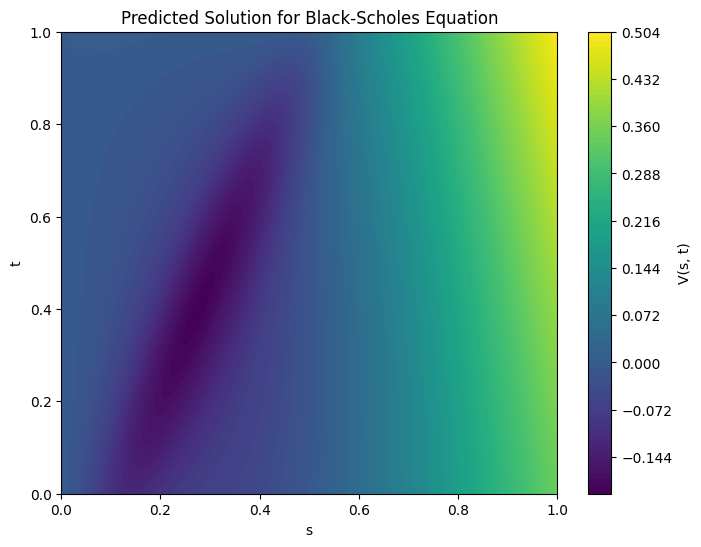

In [41]:
# Step 7: Visualize the results
# Create a grid for prediction
S_pred = torch.linspace(S_min, S_max, 100).view(-1, 1)
S_pred = (S_pred - S_min) / (S_max - S_min)
t_pred = torch.linspace(0, T, 100).view(-1, 1)

S_grid_pred, t_grid_pred = torch.meshgrid(S_pred.squeeze(), t_pred.squeeze(),
                                          indexing='ij')
S_flat = S_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)

# Predict using the trained model
V_pred = model(torch.cat((S_flat, t_flat), dim=1)).detach().numpy()
V_pred = V_pred.reshape(100, 100)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(S_grid_pred.numpy(), t_grid_pred.numpy(), V_pred, levels=100, cmap='viridis')
plt.colorbar(label='V(s, t)')
plt.xlabel('s')
plt.ylabel('t')
plt.title('Predicted Solution for Black-Scholes Equation')
plt.show()


In [42]:
# Example Usage
S = torch.tensor([100.0], dtype=torch.float32)  # Stock price
T = 1.0    # Time to maturity
t = 0.0    # Current time
K = strike  # Strike price
r = 0.05   # Risk-free rate
sigma = 0.2  # Volatility

# Compute call and put prices
call_price = black_scholes(S, t, T, K, r, sigma, option_type="call")
print(f"Call Price: {call_price.item():.4f}")

Call Price: 99.5244


In [43]:
# black_scholes(S, t, T, K, r, sigma)
V_exact = black_scholes(S_flat, t_flat, T, strike, r, sigma)
V_exact = V_exact.reshape(100, 100)

<ipython-input-2-0ed744428a21>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(tau, dtype=torch.float32)


In [44]:
V_pred

array([[-8.5184141e-04, -7.8123971e-04, -6.9576665e-04, ...,
        -4.3925806e-04, -4.4927164e-04, -4.6125217e-04],
       [-7.6347906e-03, -7.3596854e-03, -7.0706625e-03, ...,
        -1.7011329e-04, -1.4203950e-04, -1.1536642e-04],
       [-1.5409412e-02, -1.4909180e-02, -1.4392735e-02, ...,
         6.6487351e-05,  1.3387040e-04,  1.9928650e-04],
       ...,
       [ 3.2489291e-01,  3.2586214e-01,  3.2684562e-01, ...,
         4.7555509e-01,  4.7757640e-01,  4.7960380e-01],
       [ 3.3228445e-01,  3.3328745e-01,  3.3430418e-01, ...,
         4.8529497e-01,  4.8733070e-01,  4.8937201e-01],
       [ 3.3962503e-01,  3.4066138e-01,  3.4171131e-01, ...,
         4.9496880e-01,  4.9701872e-01,  4.9907389e-01]], dtype=float32)

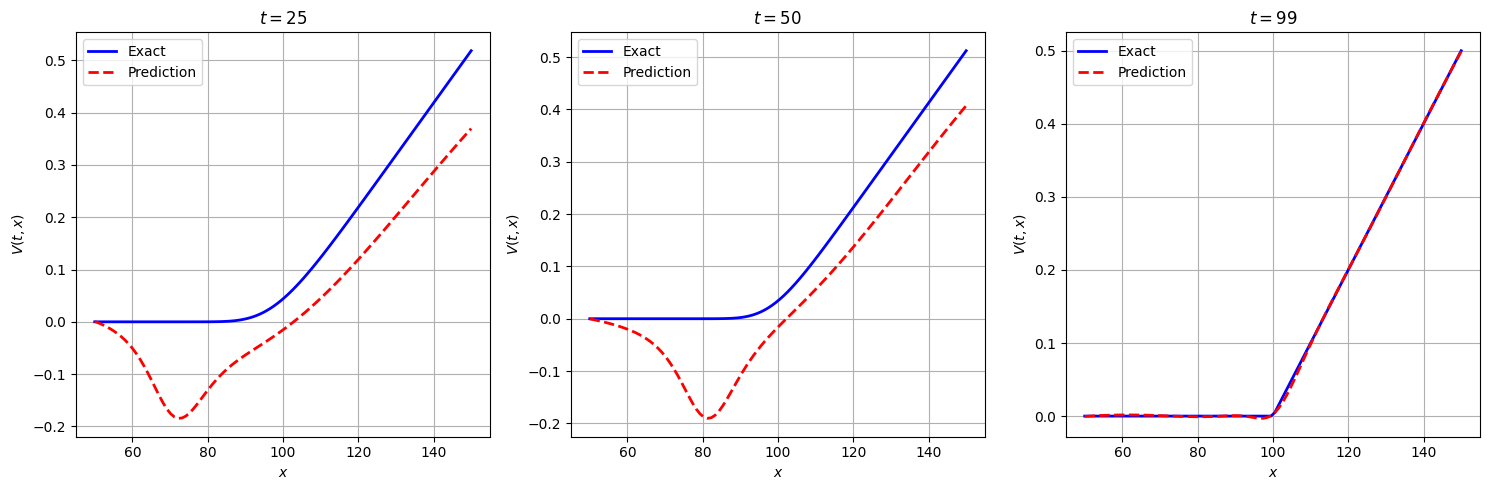

In [45]:
# Step 8: Compare predictions with exact solution at specific time slices
time_slices = [25, 50, 99]  # Time slices to compare

plt.figure(figsize=(15, 5))

for i, t_slice in enumerate(time_slices):
    # Extract points for the time slice
    t_slice_tensor = torch.full_like(S_pred, t_slice)
    V_pred_slice = V_pred[:, t_slice]

    # Compute exact solution
    V_exact_slice = V_exact[:,t_slice]

    # Plot comparison
    plt.subplot(1, 3, i + 1)
    plt.plot(s.numpy(), V_exact_slice, 'b-', label='Exact', linewidth=2)
    plt.plot(s.numpy(), V_pred_slice, 'r--', label='Prediction', linewidth=2)
    plt.title(f"$t = {t_slice}$")
    plt.xlabel("$x$")
    plt.ylabel("$V(t, x)$")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


<ipython-input-23-394df1bf8c0b>:9: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


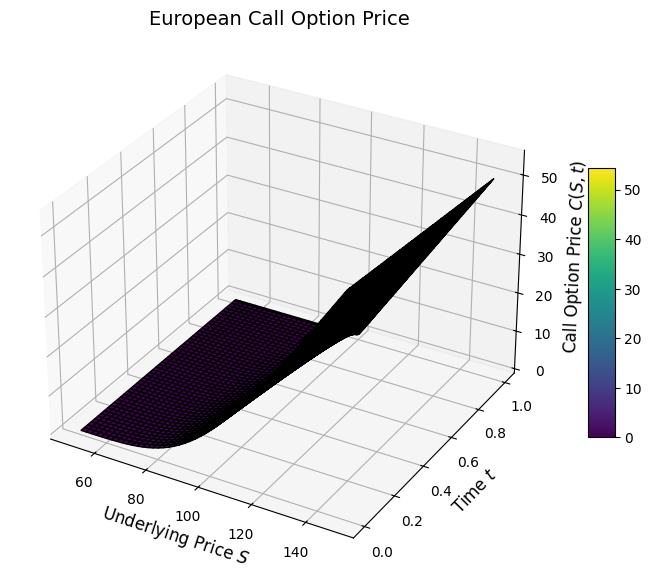

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula
def black_scholes_call(S, K, T, t, r, sigma):
    """Compute the European call option price."""
    tau = T - t  # Time to maturity
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    return call_price

# Parameters
K = 100  # Strike price
T = 1    # Time to maturity (in years)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

# Asset prices and time grid
S = np.linspace(50, 150, 100)  # Asset price range
t = np.linspace(0, T, 100)     # Time range

# Create mesh grid
S_grid, t_grid = np.meshgrid(S, t)

# Compute call option prices
call_prices = black_scholes_call(S_grid, K, T, t_grid, r, sigma)

# Plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(S_grid, t_grid, call_prices, cmap='viridis', edgecolor='k')
ax.set_title("European Call Option Price", fontsize=14)
ax.set_xlabel("Underlying Price $S$", fontsize=12)
ax.set_ylabel("Time $t$", fontsize=12)
ax.set_zlabel("Call Option Price $C(S,t)$", fontsize=12)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


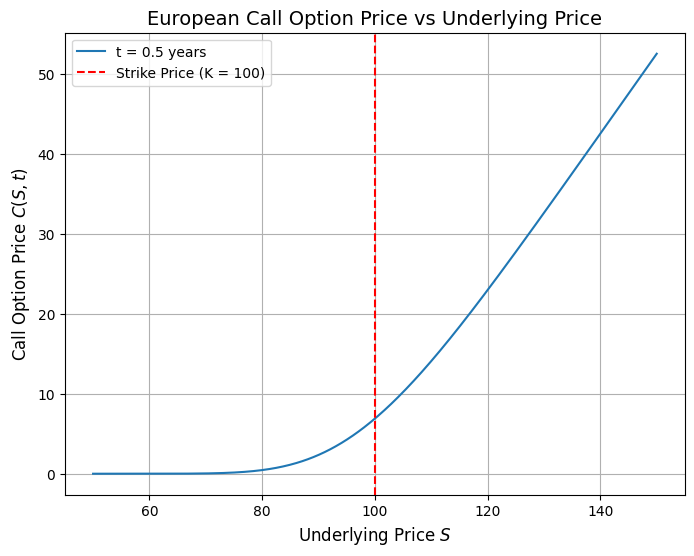

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula
def black_scholes_call(S, K, T, t, r, sigma):
    """Compute the European call option price."""
    tau = T - t  # Time to maturity
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    return call_price

# Parameters
K = 100  # Strike price
T = 1    # Time to maturity (in years)
t = 0.5  # Current time (6 months before maturity)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

# Asset prices
S = np.linspace(50, 150, 500)  # Asset price range

# Compute call option prices
call_prices = black_scholes_call(S, K, T, t, r, sigma)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(S, call_prices, label=f"t = {t} years")
plt.axvline(K, color='r', linestyle='--', label=f"Strike Price (K = {K})")
plt.title("European Call Option Price vs Underlying Price", fontsize=14)
plt.xlabel("Underlying Price $S$", fontsize=12)
plt.ylabel("Call Option Price $C(S,t)$", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


<ipython-input-24-2859add72350>:9: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


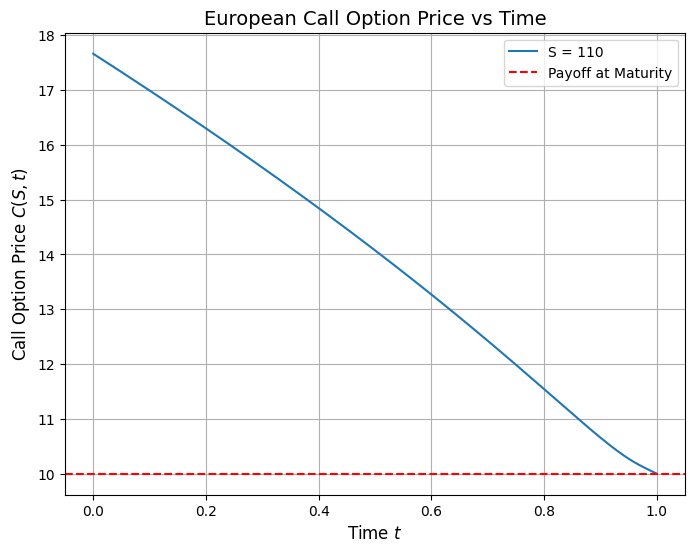

In [25]:
# Fixed parameters
S = 110  # Current stock price
K = 100  # Strike price
T = 1    # Time to maturity (in years)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

# Time grid
t = np.linspace(0, T, 500)  # Time to maturity

# Compute call option prices
call_prices = black_scholes_call(S, K, T, t, r, sigma)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t, call_prices, label=f"S = {S}")
plt.axhline(max(S - K, 0), color='r', linestyle='--', label="Payoff at Maturity")
plt.title("European Call Option Price vs Time", fontsize=14)
plt.xlabel("Time $t$", fontsize=12)
plt.ylabel("Call Option Price $C(S,t)$", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()
